In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functions.hyperloglog import HashLogLog, HyperLogLog
from functions.clustering import KMeansClustering, elbow_method, plot_wordclouds
from functions.data_preprocess import remove_html_tags, preprocess, tfidf_svd, lemmatization

# 1. Hashing

## Sequentially adding data to the HLL

In [2]:
log2m, bits = 6, 32

HLL_6 = HyperLogLog(log2m=log2m, bits=bits)

hll_6 = HLL_6.structure('hash.txt')

print(hll_6)

[23, 21, 23, 21, 23, 25, 22, 23, 23, 20, 21, 23, 21, 20, 22, 22, 21, 26, 20, 21, 26, 22, 21, 22, 22, 22, 20, 22, 25, 23, 26, 22, 24, 21, 21, 21, 21, 20, 20, 21, 24, 21, 24, 25, 22, 21, 25, 25, 25, 22, 20, 24, 22, 26, 20, 24, 24, 26, 21, 26, 20, 25, 22, 21]


## Cardinality and (relative) error of the filter

In [3]:
estimate_6 = HLL_6.cardinality(hll_6)
error_6 = HLL_6.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {}'.format(estimate_6, error_6))

Total bits: 32
Bits for the buckets: 6
Estimate: 139604896
Error: 0.13


### Observation
Maybe we can do a little bit better by increasing the lenght of the root to 11 bits. This seems to be a good point for the tradeoff between error and efficiency!

In [4]:
log2m, bits = 11, 32

HLL_11 = HyperLogLog(log2m=log2m, bits=bits)

hll_11 = HLL_11.structure('hash.txt')

estimate_11 = HLL_11.cardinality(hll_11)

error_11 = HLL_11.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {:.3f}'.format(estimate_11, error_11))

Total bits: 32
Bits for the buckets: 11
Estimate: 123189077
Error: 0.023


# Real error
To compute the real error of the algorithm we used, we have to count the exact number of unique elements that appear in the `hash.txt` file. In order to do that, there are severel options. One of those is to use shell commands, and that's what we've chosen to do.

In [5]:
!sort hash.txt | uniq | wc -l

125000000


# 2. Clustering

## 2.0 Preprocess data

### Data cleaning

In [485]:
data_path = './data/Reviews.csv'

data = pd.read_csv(data_path, index_col=False)

In [506]:
# Preprocess data
data['Text'] = data['Text'].apply(preprocess)
data['Text'] = data['Text'].apply(keep_nouns)
data['LemmatizedText'] = data['Text'].apply(lemmatization)
data = data[data['Text'] != '']

data = data.reset_index().drop(columns={'index', 'Id'})
data.to_csv('./data/clean_data.csv')

### Tf-idf representation and dimensionality reduction

In [99]:
data = pd.read_csv('./data/clean_data.csv', index_col=False)

In [103]:
data_reduced = tfidf_svd(data['LemmatizedText'])
data_reduced.shape

(566411, 17)

### Elbow method and KMeans clustering

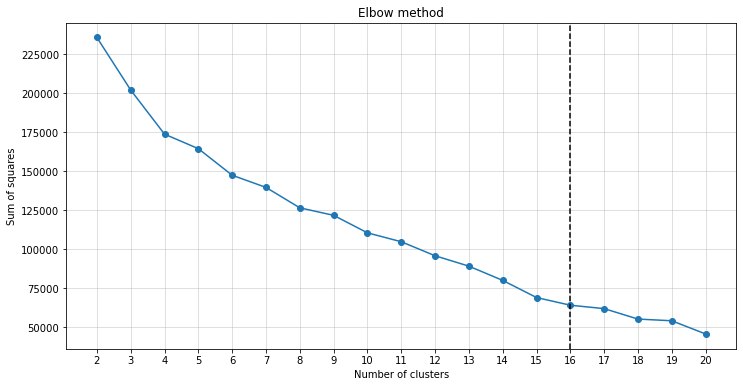

In [30]:
elbow_method(data_reduced, max_cluster_n=20)

In [104]:
model = KMeansClustering(n_clusters=16)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster'] = cluster_labels

### Wordcloud representation of the clusters

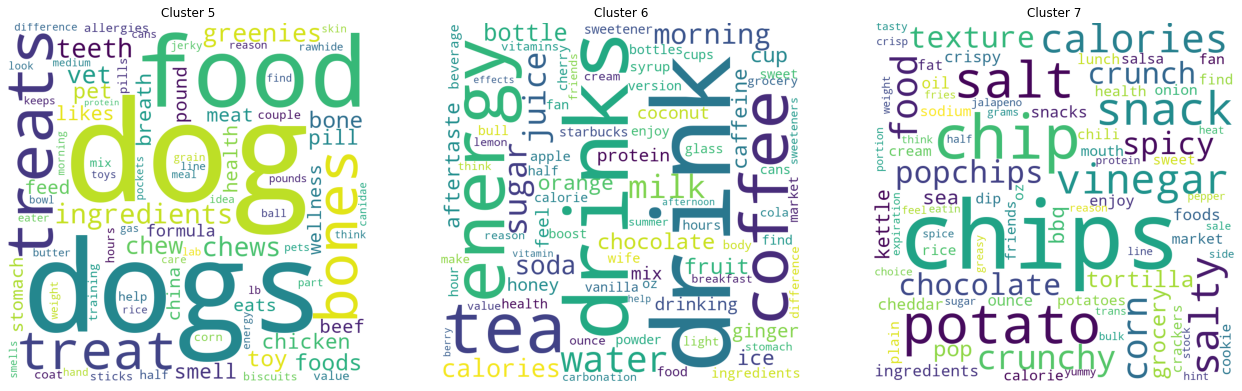

In [151]:
plot_wordclouds(data, clusters=[5, 6, 7])

### Number of elements in each cluster

In [116]:
def reviews_per_cluster(data):
    display(data.groupby('Cluster').count()['Text'].reset_index().rename(columns={'Text': 'Reviews Number'}))

In [121]:
reviews_per_cluster(data)

,Cluster,Reviews Number
0,0,45688
1,1,38920
2,2,21726
3,3,17056
4,4,12878
5,5,26304
6,6,13322
7,7,16922
8,8,29533
9,9,18685
